In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

from ppcollapse import setup_logger
from ppcollapse.utils.config import ConfigManager
from ppcollapse.utils.database import get_collapses_df

logger = setup_logger(level="INFO", name="ppcx")
config = ConfigManager(config_path="config.yaml")
db_engine = create_engine(config.db_url)

In [2]:
engine = create_engine(config.db_url)
df = get_collapses_df(engine)
if df.empty:
    logger.warning("No collapses found in database.")
df

,id,date,image_id,geom_wkt,area,volume
0,496,2023-09-30,40141,"POLYGON((2905.1149606299323 3983.414173228345,...",75287.49331,NaN
1,495,2023-09-12,39963,"POLYGON((2748.982677165365 4139.546456692912,2...",66922.73695,NaN
2,493,2023-09-11,39949,POLYGON((2663.2629921259954 3766.0535433070845...,72447.69367,NaN
3,494,2023-09-11,39949,POLYGON((2023.4267716535542 3707.8866141732274...,79983.00359,NaN
4,492,2023-09-10,39937,"POLYGON((2069.348031496074 3557.87716535433,21...",238168.27834,NaN
...,...,...,...,...,...,...
490,6,2014-05-31,65275,"POLYGON((2636.2204724409453 4228.83779527559,2...",809189.81559,15000.0
491,5,2014-05-27,65179,POLYGON((2428.0440944881893 3820.6488188976373...,135110.73117,NaN
492,4,2014-05-18,64963,POLYGON((1662.6897637795282 3814.5259842519677...,165762.23923,11000.0
493,3,2014-05-17,64938,"POLYGON((2395.388976377953 3832.894488188976,2...",171791.73680,NaN


In [3]:
# prepare data
df["date"] = pd.to_datetime(df["date"])
# keep only positive values for log scale and regression
mask_pos = (df["area"] > 0) & (df["volume"] > 0)
df_pos = df.loc[mask_pos].reset_index(drop=True)
if df_pos.empty:
    raise RuntimeError("No positive area/volume points available for plotting.")

/tmp/ipykernel_197757/168241970.py:5: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date_nums = mdates.date2num(np.array(df_pos["date"].dt.to_pydatetime()))


Text(0, 0.5, 'Volume [m$^3$]')

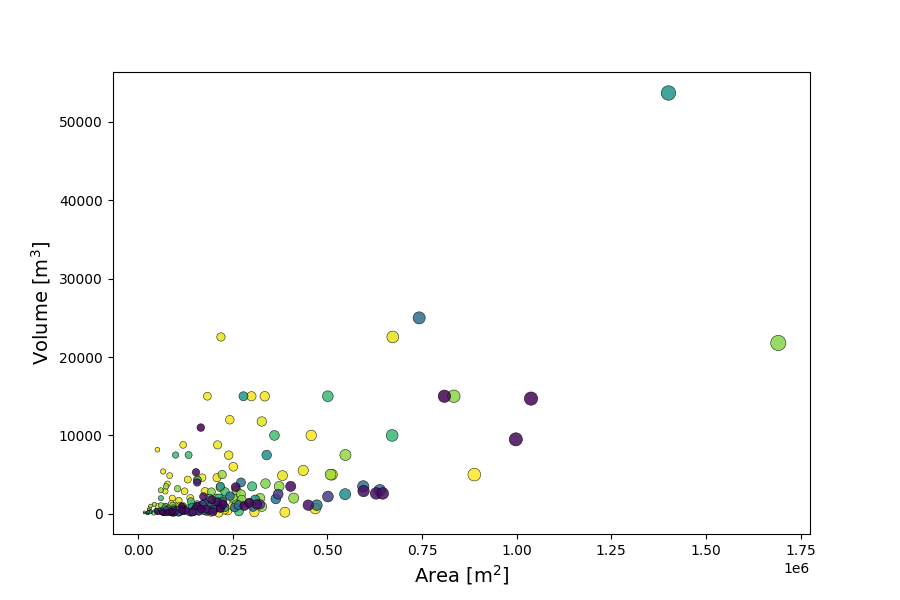

In [4]:
# Make area-volume plots for all collapses in the DB - Linear scale
fig, ax = plt.subplots(figsize=(9, 6))

# color by date (older -> darker)
date_nums = mdates.date2num(np.array(df_pos["date"].dt.to_pydatetime()))
norm = plt.Normalize(date_nums.min(), date_nums.max())
cmap = plt.get_cmap("viridis")

# marker size from area (scaled)
sizes_norm = plt.Normalize(
    np.sqrt(df_pos["area"].astype(float)).min(),
    np.sqrt(df_pos["area"].astype(float)).max(),
)
min_size, max_size = 2, 120
sizes = min_size + (max_size - min_size) * sizes_norm(
    np.sqrt(df_pos["area"].astype(float))
)

# plot
sc = ax.scatter(
    df_pos["area"],
    df_pos["volume"],
    c=date_nums,
    cmap=cmap,
    norm=norm,
    s=sizes,
    alpha=0.85,
    edgecolor="k",
    linewidth=0.4,
)

ax.set_xlabel("Area [m$^2$]", fontsize=14)
ax.set_ylabel("Volume [m$^3$]", fontsize=14)

In [5]:
# fit a power-law (log-log linear fit): log(vol)=a*log(area)+b
logA = np.log10(df_pos["area"].astype(float))
logV = np.log10(df_pos["volume"].astype(float))
coeffs = np.polyfit(logA, logV, deg=1)
a, b = coeffs
pred_logV = np.polyval(coeffs, logA)
ss_tot = np.sum((logV - logV.mean()) ** 2)
ss_res = np.sum((logV - pred_logV) ** 2)
r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

/tmp/ipykernel_1307817/493748752.py:5: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date_nums = mdates.date2num(df_pos["date"].dt.to_pydatetime())


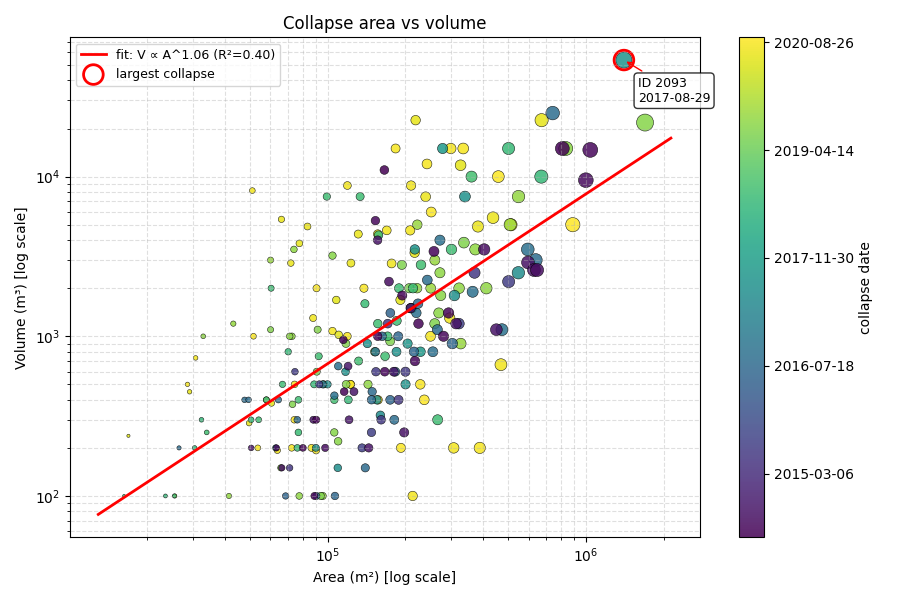

In [9]:
# Make a Log-Log plot with regression
fig, ax = plt.subplots(figsize=(9, 6))

# color by date (older -> darker)
date_nums = mdates.date2num(df_pos["date"].dt.to_pydatetime())
norm = plt.Normalize(date_nums.min(), date_nums.max())
cmap = plt.get_cmap("viridis")

# marker size from area (scaled)
sizes_norm = plt.Normalize(
    np.sqrt(df_pos["area"].astype(float)).min(),
    np.sqrt(df_pos["area"].astype(float)).max(),
)
min_size, max_size = 5, 150
sizes = min_size + (max_size - min_size) * sizes_norm(
    np.sqrt(df_pos["area"].astype(float))
)

# scatter
sc = ax.scatter(
    df_pos["area"],
    df_pos["volume"],
    c=date_nums,
    cmap=cmap,
    norm=norm,
    s=sizes,
    alpha=0.85,
    edgecolor="k",
    linewidth=0.4,
)

# regression line in original space
area_range = np.logspace(
    np.log10(df_pos["area"].min()) - 0.1, np.log10(df_pos["area"].max()) + 0.1, 200
)
vol_pred = 10 ** (a * np.log10(area_range) + b)
ax.plot(
    area_range, vol_pred, color="red", lw=2, label=f"fit: V ∝ A^{a:.2f} (R²={r2:.2f})"
)

# highlight largest collapse by volume
idx_max = df_pos["volume"].idxmax()
ax.scatter(
    [df_pos.loc[idx_max, "area"]],
    [df_pos.loc[idx_max, "volume"]],
    s=200,
    facecolor="none",
    edgecolor="red",
    linewidth=2,
    label="largest collapse",
)
ax.annotate(
    f"ID {int(df_pos.loc[idx_max, 'id'])}\n{df_pos.loc[idx_max, 'date'].date()}",
    xy=(df_pos.loc[idx_max, "area"], df_pos.loc[idx_max, "volume"]),
    xytext=(10, -30),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", color="red"),
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Area (m²) [log scale]")
ax.set_ylabel("Volume (m³) [log scale]")
ax.set_title("Collapse area vs volume")

# colorbar for date
cbar = fig.colorbar(sc, ax=ax)
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
cbar.set_label("collapse date")

ax.grid(which="both", linestyle="--", alpha=0.4)
ax.legend(loc="upper left", fontsize=9)
fig.tight_layout()

out_path = "output/collapses_area_volume_loglog.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")

/tmp/ipykernel_197757/4037282948.py:5: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date_nums = mdates.date2num(np.array(df_pos["date"].dt.to_pydatetime()))


Saved plot to output/collapses_area_volume_linear.png


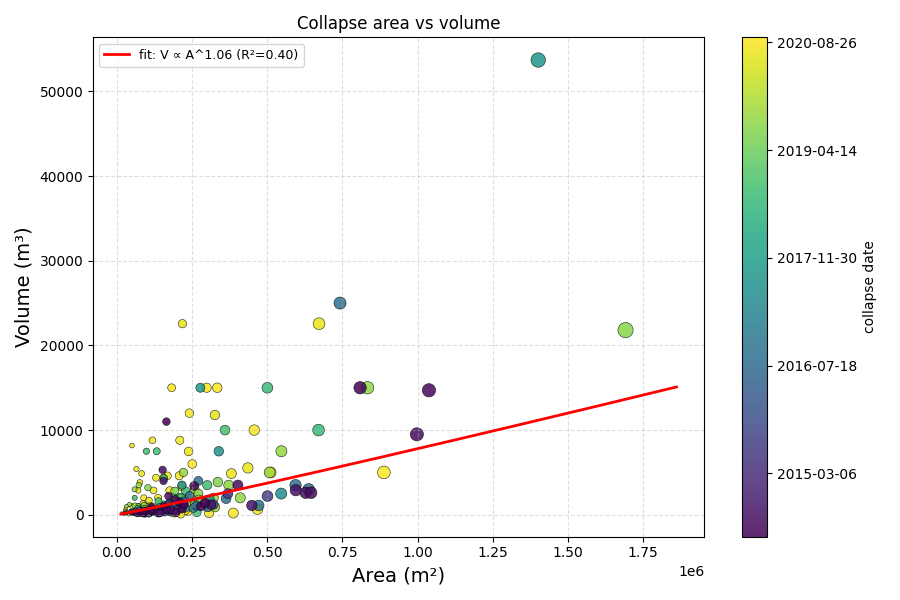

In [6]:
# Make area-volume plots for all collapses in the DB - Linear scale
fig, ax = plt.subplots(figsize=(9, 6))

# color by date (older -> darker)
date_nums = mdates.date2num(np.array(df_pos["date"].dt.to_pydatetime()))
norm = plt.Normalize(date_nums.min(), date_nums.max())
cmap = plt.get_cmap("viridis")

# marker size from area (scaled)
sizes_norm = plt.Normalize(
    np.sqrt(df_pos["area"].astype(float)).min(),
    np.sqrt(df_pos["area"].astype(float)).max(),
)
min_size, max_size = 2, 120
sizes = min_size + (max_size - min_size) * sizes_norm(
    np.sqrt(df_pos["area"].astype(float))
)

# plot
sc = ax.scatter(
    df_pos["area"],
    df_pos["volume"],
    c=date_nums,
    cmap=cmap,
    norm=norm,
    s=sizes,
    alpha=0.85,
    edgecolor="k",
    linewidth=0.4,
)

ax.set_xlabel("Area [m$^2$]", fontsize=14)
ax.set_ylabel("Volume [m$^3$]", fontsize=14)

# Overlay the power-law fit in linuar scale
area_range = np.linspace(
    df_pos["area"].min() - 0.1 * df_pos["area"].min(),
    df_pos["area"].max() + 0.1 * df_pos["area"].max(),
    200,
)
vol_pred = 10 ** (a * np.log10(area_range) + b)
ax.plot(
    area_range, vol_pred, color="red", lw=2, label=f"fit: V ∝ A^{a:.2f} (R²={r2:.2f})"
)

ax.set_xlabel("Area (m²)")
ax.set_ylabel("Volume (m³)")
ax.set_title("Collapse area vs volume")

# colorbar for date
cbar = fig.colorbar(sc, ax=ax)
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
cbar.set_label("collapse date")

ax.grid(which="both", linestyle="--", alpha=0.4)
ax.legend(loc="upper left", fontsize=9)
fig.tight_layout()

out_path = "output/collapses_area_volume_linear.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
print(f"Saved plot to {out_path}")